# Fashion_MNIST Classification Based on CNN

2022217367徐德润

用卷积神经网络（CNN）对 Fashion_MNIST dataset 进行分类，并可视化结果。

## 导入用到的包

In [40]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## 加载数据集并进行初步探索

In [41]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

首先，我们可以查看数据的形状和类别分布情况。

In [42]:
# 查看训练和测试数据的形状
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)

# 查看类别分布
unique, counts = np.unique(y_train, return_counts=True)
print("训练集类别分布:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("测试集类别分布:", dict(zip(unique, counts)))

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_test shape: (10000, 28, 28) y_test shape: (10000,)
训练集类别分布: {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
测试集类别分布: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


### 可视化样本图像
我们可以随机绘制一些样本图像来直观地观察数据集中的图像：

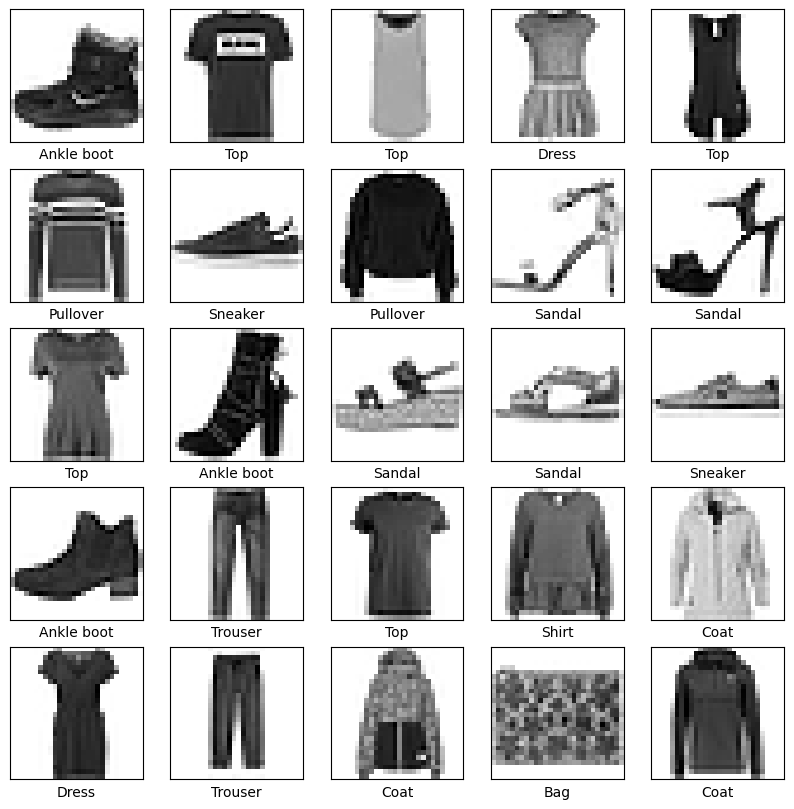

In [43]:
# 定义类别标签
class_names = ['Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 可视化一些训练样本
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

### 可视化灰度直方图
绘制一些样本图像的灰度直方图，了解像素值的分布情况：

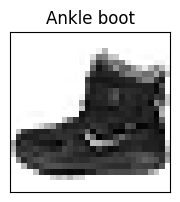

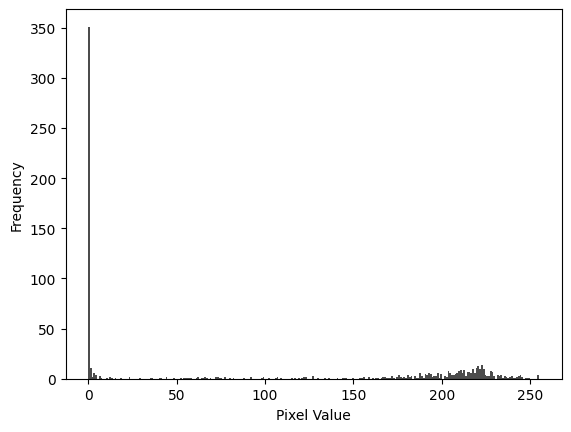

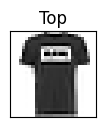

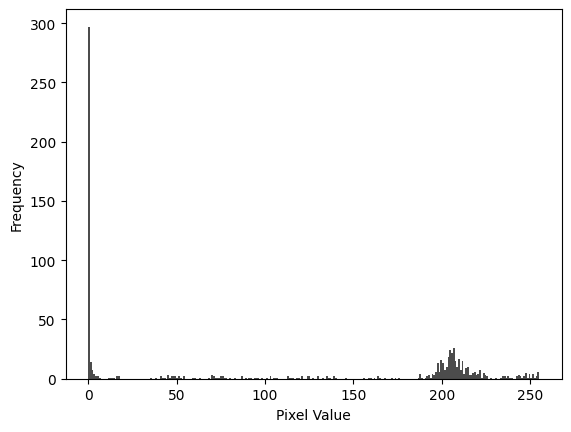

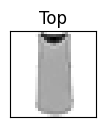

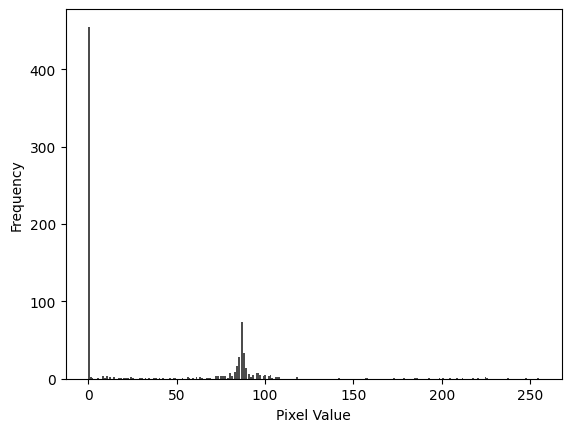

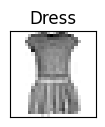

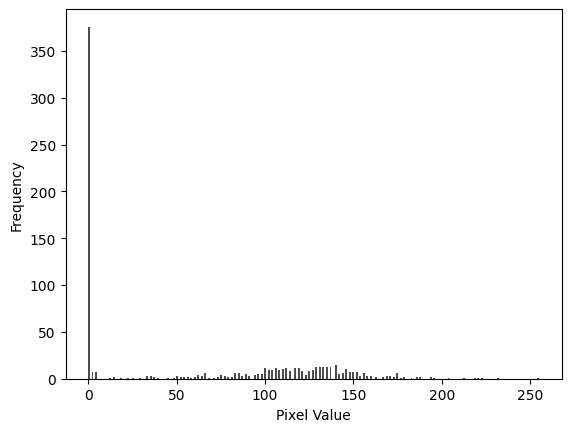

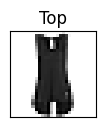

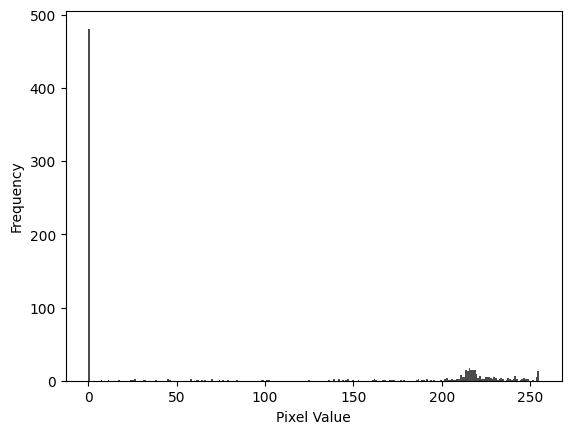

In [44]:
# 绘制灰度直方图
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.title(class_names[y_train[i]])
    plt.figure()
    plt.hist(x_train[i].ravel(), bins=256, color='black', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

### 查看图像的基本统计信息
通过查看图像像素值的基本统计信息，了解图像的亮度和对比度等特性。

In [45]:
# 计算基本统计信息
print(f"训练集图像像素值范围: {x_train.min()} - {x_train.max()}")
print(f"测试集图像像素值范围: {x_test.min()} - {x_test.max()}")

print(f"训练集图像像素值平均值: {x_train.mean():.2f}")
print(f"训练集图像像素值标准差: {x_train.std():.2f}")

print(f"测试集图像像素值平均值: {x_test.mean():.2f}")
print(f"测试集图像像素值标准差: {x_test.std():.2f}")

训练集图像像素值范围: 0 - 255
测试集图像像素值范围: 0 - 255
训练集图像像素值平均值: 72.94
训练集图像像素值标准差: 90.02
测试集图像像素值平均值: 73.15
测试集图像像素值标准差: 89.87


## 数据预处理
通过以上对数据的探索，我们对数据有了初步的理解。在对数据集进行分类之前，我们需要将数据拆为训练/验证数据集。我们取训练集的20%作为验证集。

In [46]:
# 加载数据集
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

# 打印原始数据的形状
print("原始")
print("x_train_full shape:", x_train_full.shape, "y_train_full shape:", y_train_full.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)

# 将数据集拆分为训练集和验证集
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)

# 打印拆分后的数据形状
print("拆分后")
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape, "y_val shape:", y_val.shape)

原始
x_train_full shape: (60000, 28, 28) y_train_full shape: (60000,)
x_test shape: (10000, 28, 28) y_test shape: (10000,)
拆分后
x_train shape: (48000, 28, 28) y_train shape: (48000,)
x_val shape: (12000, 28, 28) y_val shape: (12000,)


将图像数据进行归一化，使得每个像素的值都在0到1之间。这一步可以通过将每个像素值除以255来实现。

In [47]:
# 将图像数据归一化到0-1之间
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# 打印归一化后的像素值范围
print(f"归一化后训练集图像像素值范围: {x_train.min()} - {x_train.max()}")
print(f"归一化后验证集图像像素值范围: {x_val.min()} - {x_val.max()}")
print(f"归一化后测试集图像像素值范围: {x_test.min()} - {x_test.max()}")

归一化后训练集图像像素值范围: 0.0 - 1.0
归一化后验证集图像像素值范围: 0.0 - 1.0
归一化后测试集图像像素值范围: 0.0 - 1.0


CNN的输入是包含图像像素值的三维张量，而FASHION_MNIST 数据集的图像是灰度图像，只有一个颜色通道。所以，我们需要将输入数据的形状从 (28, 28) 修改为 (28, 28, 1)。

In [48]:
# 修改输入数据的形状以添加通道维度
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# 打印修改后的数据形状
print("修改后的 x_train shape:", x_train.shape)
print("修改后的 x_val shape:", x_val.shape)
print("修改后的 x_test shape:", x_test.shape)

修改后的 x_train shape: (48000, 28, 28, 1)
修改后的 x_val shape: (12000, 28, 28, 1)
修改后的 x_test shape: (10000, 28, 28, 1)


此外，因为在分类任务中，神经网络的输出层通常是一个 softmax 层，它会输出每个类别的概率。在进行训练时，使用 one-hot 编码的标签可以计算交叉熵损失，从而指导模型学习。故还需要将类别标签进行one-hot编码。

In [49]:
# 将类别标签进行 one-hot 编码
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

# 打印 one-hot 编码后的标签形状
print("One-hot 编码后的 y_train shape:", y_train.shape)
print("One-hot 编码后的 y_val shape:", y_val.shape)
print("One-hot 编码后的 y_test shape:", y_test.shape)

One-hot 编码后的 y_train shape: (48000, 10)
One-hot 编码后的 y_val shape: (12000, 10)
One-hot 编码后的 y_test shape: (10000, 10)


最终，我们的训练规模为：

In [50]:
# 打印训练集规模
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (48000, 28, 28, 1) y_train shape: (48000, 10)


## 定义CNN模型
使用 Keras 来定义一个CNN模型，包括卷积层、池化层、全连接层等。

In [51]:
model = models.Sequential()

# 定义输入的形状
model.add(layers.Input(shape=(28, 28, 1)))

# 第一层卷积层，包含32个过滤器，卷积核大小为3x3，激活函数为ReLU
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# 第一次最大池化层，池化窗口大小为2x2
model.add(layers.MaxPooling2D((2, 2)))
# 添加 Dropout 层，丢弃率为25%
model.add(layers.Dropout(0.25))

# 第二层卷积层，包含64个过滤器，卷积核大小为3x3，激活函数为ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# 第二次最大池化层，池化窗口大小为2x2
model.add(layers.MaxPooling2D((2, 2)))
# 添加 Dropout 层，丢弃率为25%
model.add(layers.Dropout(0.25))

# 第三层卷积层，包含64个过滤器，卷积核大小为3x3，激活函数为ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# 添加 Dropout 层，丢弃率为25%
model.add(layers.Dropout(0.25))

# 将卷积层的输出展开为一维向量
model.add(layers.Flatten())

# 全连接层，包含64个神经元，激活函数为ReLU
model.add(layers.Dense(64, activation='relu'))
# 添加 Dropout 层，丢弃率为50%
model.add(layers.Dropout(0.5))

# 输出层，包含10个神经元（对应10个类别），激活函数为softmax
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

## 编译模型
下面，我们编译模型。

In [52]:
# 编译模型
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 训练模型
使用`ModelCheckpoint`回调函数，在每个epoch后保存模型的权重。

In [53]:
checkpointer = ModelCheckpoint(filepath='./models/model.best.keras', verbose = 1, save_best_only=True)
history = model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10,
         validation_data=(x_val, y_val),
         callbacks=[checkpointer])

Epoch 1/10
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5740 - loss: 1.1517
Epoch 1: val_loss improved from inf to 0.49109, saving model to ./models/model.best.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.5745 - loss: 1.1504 - val_accuracy: 0.8078 - val_loss: 0.4911
Epoch 2/10
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7913 - loss: 0.5678
Epoch 2: val_loss improved from 0.49109 to 0.40363, saving model to ./models/model.best.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7913 - loss: 0.5677 - val_accuracy: 0.8517 - val_loss: 0.4036
Epoch 3/10
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8265 - loss: 0.4777
Epoch 3: val_loss improved from 0.40363 to 0.35030, saving model to ./models/model.best.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8265 - loss: 0.4776 - val_accuracy: 0.8693 - val_loss: 0.3503
Epoch 4/10
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8462 - loss: 0.4251
Epoch 4: val_loss

## 评估模型

### 评估测试集上的性能
使用测试集评估模型的准确性和损失。

In [54]:
# 评估测试集上的性能
model.load_weights('./models/model.best.keras')
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9014 - loss: 0.2877
Test Loss: 0.27766546607017517
Test Accuracy: 0.8998000025749207


### 绘制训练和验证的损失和准确性曲线
通过绘制训练过程中的损失和准确性曲线，可以直观地了解模型的学习过程和是否发生过拟合。

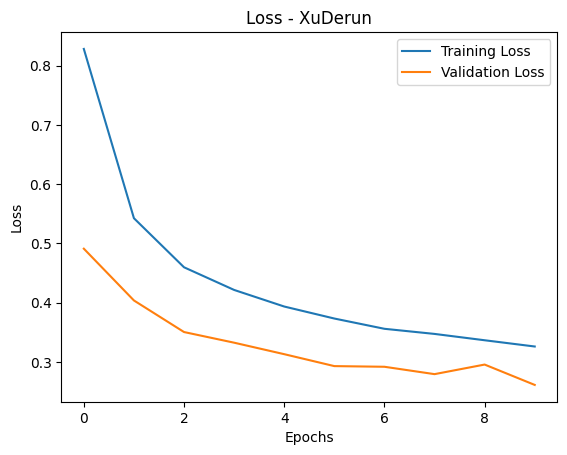

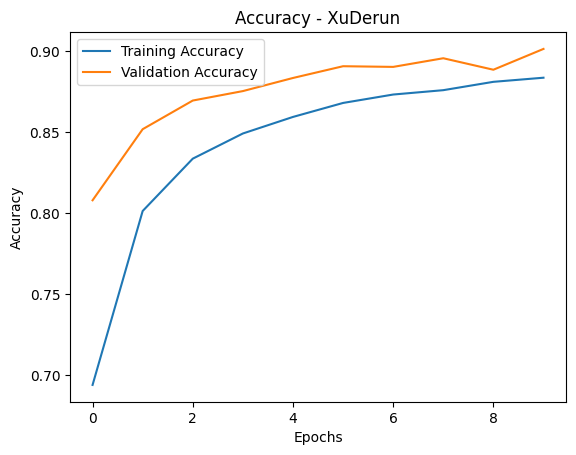

In [55]:
# 绘制训练和验证的损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss - XuDerun')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练和验证的准确性曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy - XuDerun')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 查看混淆矩阵
通过混淆矩阵，查看详细的分类结果信息，包括准确分类和错误分类的数量。

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


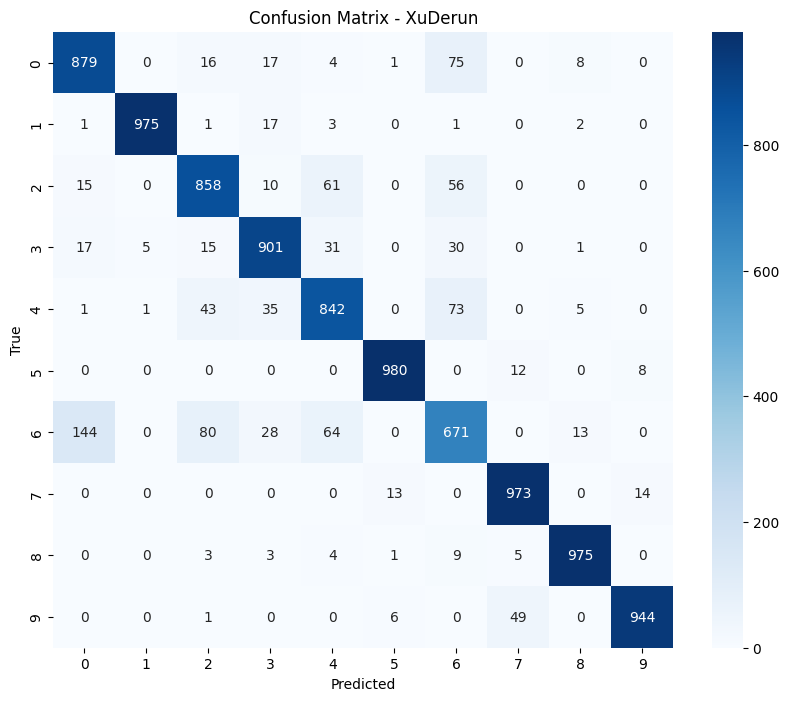

In [56]:
# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XuDerun')
plt.show()

### 计算分类报告
分类报告提供了每个类别的精确度、召回率和 F1 分数。

In [57]:
# 计算分类报告
class_report = classification_report(y_true, y_pred_classes)
print(class_report)

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.84      0.86      0.85      1000
           3       0.89      0.90      0.90      1000
           4       0.83      0.84      0.84      1000
           5       0.98      0.98      0.98      1000
           6       0.73      0.67      0.70      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## 可视化预测结果

我们从测试数据集中随机选15张图像，它们带有真值标签。用我们训练出来的模型进行预测，并展示预测结果。

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Text(0.5, 0.98, 'CNN Predictions vs True Labels - XuDerun')

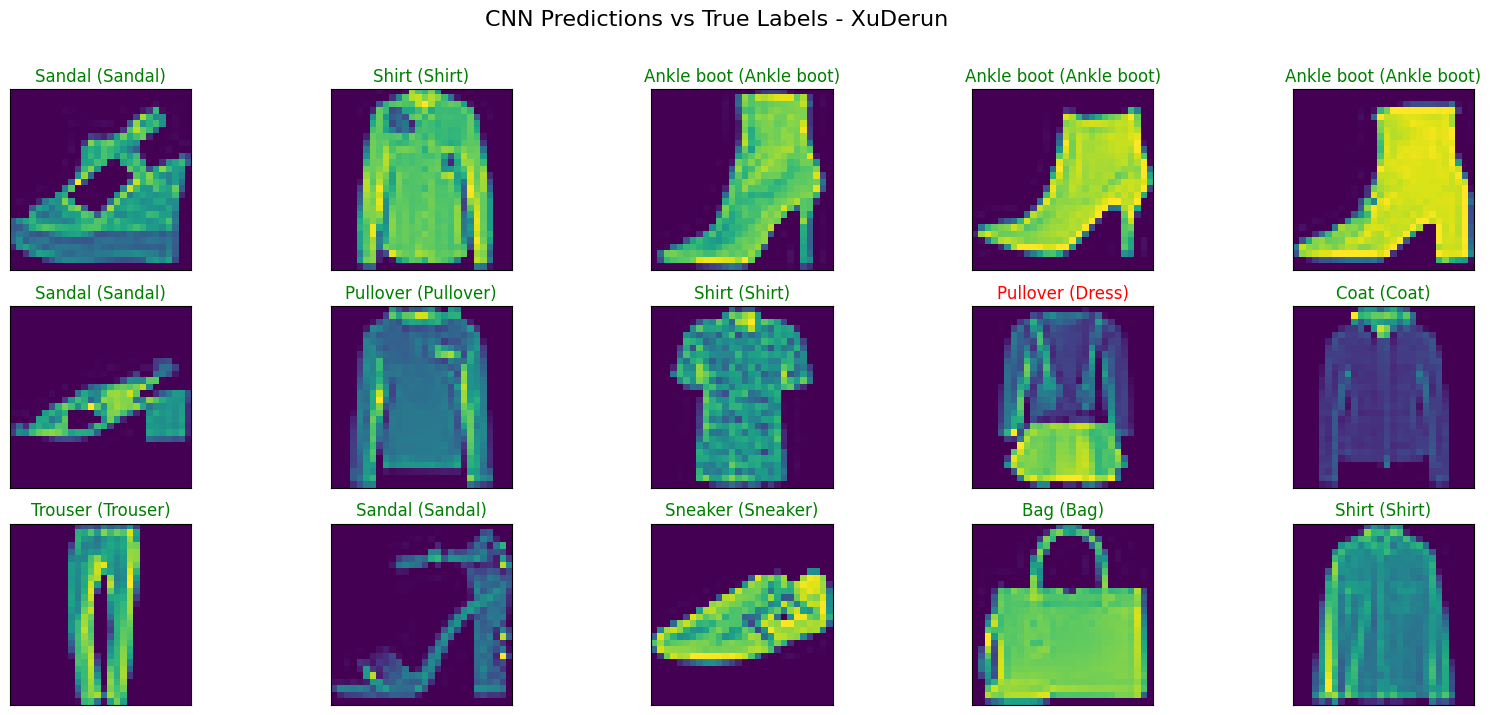

In [58]:
y_hat = model.predict(x_test)

# 从测试数据集中打印出15张图像，并设置带有预测的标题和真值标签
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.suptitle('CNN Predictions vs True Labels - XuDerun', fontsize=16)